# Analysis of Noise-Perturbed Student-Teacher Network

This notebook analyses the results from the grid search over noise levels in the feedforward noisy units experiment.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.dpi"] = 100

In [20]:
# Path to grid search results
grid_search_dir = Path(
    "/tungstenfs/scratch/gzenke/bedfrory/dp-simulations/noisy-weights/varying-noise"
)

# Find all run directories
run_dirs = sorted(
    [
        d
        for d in grid_search_dir.iterdir()
        if d.is_dir() and d.name.startswith("noise-")
    ]
)
print(f"Found {len(run_dirs)} runs:")
for d in run_dirs:
    print(f"  {d.name}")

Found 10 runs:
  noise-0.05
  noise-0.10
  noise-0.15
  noise-0.20
  noise-0.25
  noise-0.30
  noise-0.35
  noise-0.40
  noise-0.45
  noise-0.50


In [21]:
# Extract noise levels and load final metrics from each run
results = []

for run_dir in run_dirs:
    # Extract noise fraction from directory name (now "noise-X" format)
    match = re.search(r"noise-([\d.]+)", run_dir.name)
    if match:
        noise_fraction = float(match.group(1))
    else:
        continue

    # Load training metrics
    metrics_path = run_dir / "training_metrics.csv"
    if not metrics_path.exists():
        print(f"Warning: {metrics_path} not found, skipping")
        continue

    df = pd.read_csv(metrics_path)

    # Get final row (last epoch)
    final_row = df.iloc[-1]

    # New flattened column names: scaling_factors/X_value instead of scaling_factors/X/value
    results.append(
        {
            "noise_fraction": noise_fraction,
            "final_epoch": final_row["epoch"],
            # Scaling factors - learned values (normalized so target=1)
            "exc_to_exc_value": final_row["scaling_factors/excitatory_to_excitatory_value"],
            "exc_to_inh_value": final_row["scaling_factors/excitatory_to_inhibitory_value"],
            "inh_to_exc_value": final_row["scaling_factors/inhibitory_to_excitatory_value"],
            "inh_to_inh_value": final_row["scaling_factors/inhibitory_to_inhibitory_value"],
            "mitral_to_exc_value": final_row["scaling_factors/mitral_to_excitatory_value"],
            "mitral_to_inh_value": final_row["scaling_factors/mitral_to_inhibitory_value"],
            # Scaling factors - targets (should all be 1.0 now)
            "exc_to_exc_target": final_row["scaling_factors/excitatory_to_excitatory_target"],
            "exc_to_inh_target": final_row["scaling_factors/excitatory_to_inhibitory_target"],
            "inh_to_exc_target": final_row["scaling_factors/inhibitory_to_excitatory_target"],
            "inh_to_inh_target": final_row["scaling_factors/inhibitory_to_inhibitory_target"],
            "mitral_to_exc_target": final_row["scaling_factors/mitral_to_excitatory_target"],
            "mitral_to_inh_target": final_row["scaling_factors/mitral_to_inhibitory_target"],
            # Firing rates - student and teacher
            "student_firing_rate_mean": final_row["firing_rate/student_mean"],
            "student_firing_rate_exc": final_row["firing_rate/student_excitatory_mean"],
            "student_firing_rate_inh": final_row["firing_rate/student_inhibitory_mean"],
            "teacher_firing_rate_mean": final_row["firing_rate/teacher_mean"],
            "teacher_firing_rate_exc": final_row["firing_rate/teacher_excitatory_mean"],
            "teacher_firing_rate_inh": final_row["firing_rate/teacher_inhibitory_mean"],
            # Loss
            "final_loss": final_row["total_loss"],
        }
    )

results_df = pd.DataFrame(results).sort_values("noise_fraction").reset_index(drop=True)
print(f"\nLoaded results from {len(results_df)} runs")
results_df


Loaded results from 10 runs


,noise_fraction,final_epoch,exc_to_exc_value,exc_to_inh_value,inh_to_exc_value,inh_to_inh_value,mitral_to_exc_value,mitral_to_inh_value,exc_to_exc_target,exc_to_inh_target,...,inh_to_inh_target,mitral_to_exc_target,mitral_to_inh_target,student_firing_rate_mean,student_firing_rate_exc,student_firing_rate_inh,teacher_firing_rate_mean,teacher_firing_rate_exc,teacher_firing_rate_inh,final_loss
0,0.05,1000.0,1.002356,1.012324,0.990682,0.994696,0.999626,1.005482,1.0,1.0,...,1.0,1.0,1.0,1.16388,0.534200,3.6826,1.1591,0.528825,3.6802,0.702007
1,0.10,1000.0,0.999136,1.014608,0.983907,0.992942,0.997105,1.002395,1.0,1.0,...,1.0,1.0,1.0,1.16770,0.538200,3.6857,1.1591,0.528825,3.6802,1.416816
2,0.15,1000.0,0.990255,1.001079,0.979288,0.998456,0.990016,0.994114,1.0,1.0,...,1.0,1.0,1.0,1.16940,0.539550,3.6888,1.1591,0.528825,3.6802,2.141258
3,0.20,1000.0,0.973662,0.973667,0.976368,1.001211,0.981191,0.970535,1.0,1.0,...,1.0,1.0,1.0,1.16972,0.541225,3.6837,1.1591,0.528825,3.6802,2.919973
4,0.25,1000.0,0.948942,0.941153,0.972588,1.003773,0.968195,0.933513,1.0,1.0,...,1.0,1.0,1.0,1.16900,0.541150,3.6804,1.1591,0.528825,3.6802,3.770496
5,0.30,1000.0,0.919084,0.903109,0.969144,0.997262,0.951075,0.888870,1.0,1.0,...,1.0,1.0,1.0,1.16818,0.541450,3.6751,1.1591,0.528825,3.6802,4.711557
6,0.35,1000.0,0.884407,0.852029,0.961657,0.991389,0.922889,0.832407,1.0,1.0,...,1.0,1.0,1.0,1.16226,0.540000,3.6513,1.1591,0.528825,3.6802,5.743649
7,0.40,1000.0,0.842829,0.804123,0.950217,0.986560,0.893853,0.777500,1.0,1.0,...,1.0,1.0,1.0,1.15640,0.536650,3.6354,1.1591,0.528825,3.6802,6.870010
8,0.45,1000.0,0.799146,0.751986,0.936383,0.975406,0.862886,0.729061,1.0,1.0,...,1.0,1.0,1.0,1.14942,0.533175,3.6144,1.1591,0.528825,3.6802,8.046754
9,0.50,1000.0,0.756239,0.709033,0.919200,0.957651,0.830003,0.680589,1.0,1.0,...,1.0,1.0,1.0,1.13794,0.528575,3.5754,1.1591,0.528825,3.6802,9.142648


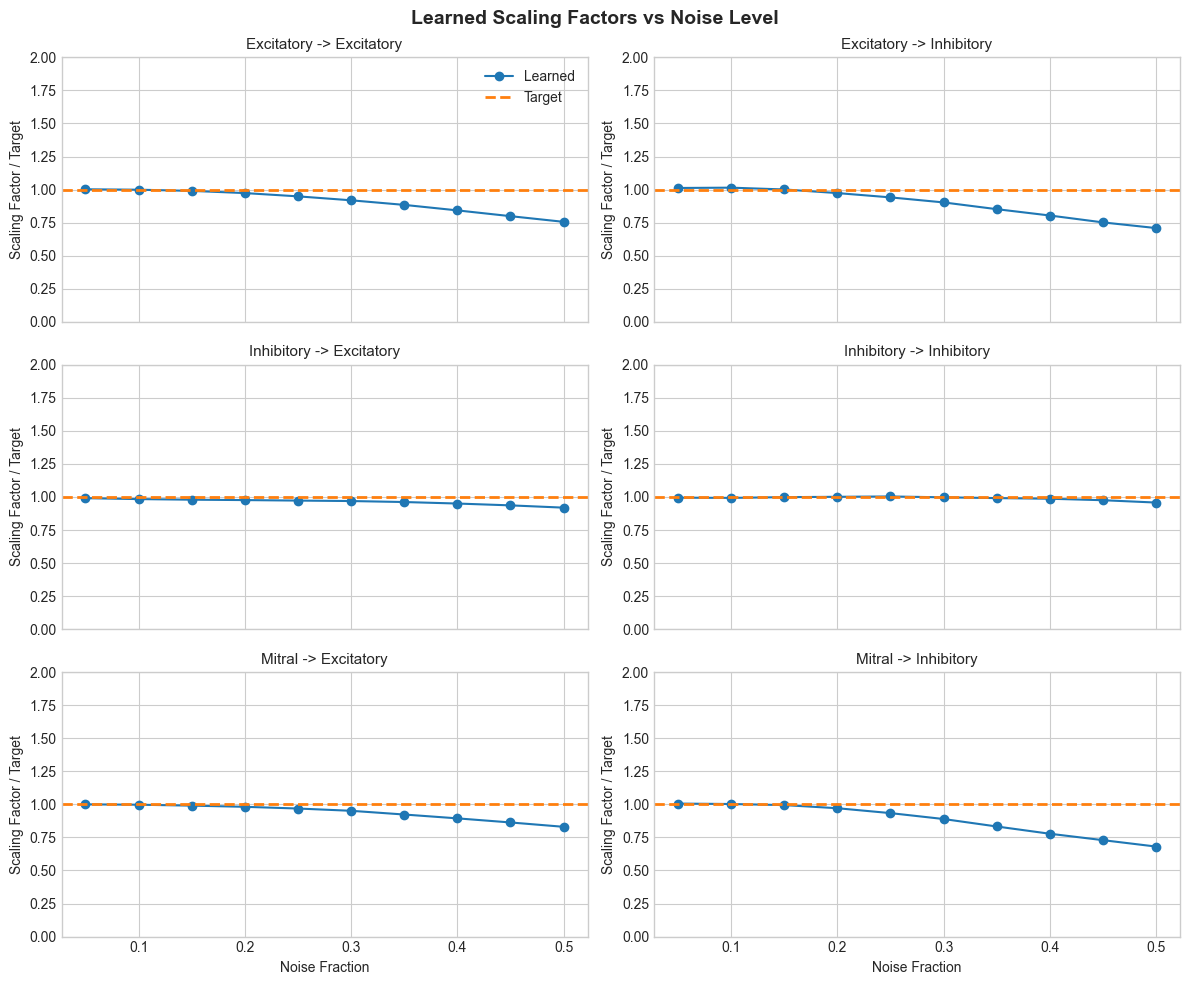

In [22]:
# Plot learned scaling factors vs noise level (3x2 subplot)
# Since targets are now normalized to 1.0, we plot value directly
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=True)

scaling_factor_pairs = [
    ("exc_to_exc", "Excitatory -> Excitatory"),
    ("exc_to_inh", "Excitatory -> Inhibitory"),
    ("inh_to_exc", "Inhibitory -> Excitatory"),
    ("inh_to_inh", "Inhibitory -> Inhibitory"),
    ("mitral_to_exc", "Mitral -> Excitatory"),
    ("mitral_to_inh", "Mitral -> Inhibitory"),
]

noise_levels = results_df["noise_fraction"].values

for idx, (key, title) in enumerate(scaling_factor_pairs):
    ax = axes.flat[idx]

    # Get values (already normalized so target=1)
    values = results_df[f"{key}_value"].values

    # Plot learned values
    ax.plot(noise_levels, values, "o-", color="C0", label="Learned", markersize=6)

    # Plot target line at 1.0
    ax.axhline(y=1.0, color="C1", linestyle="--", linewidth=2, label="Target")

    ax.set_title(title, fontsize=11)
    ax.set_ylabel("Scaling Factor / Target")
    ax.set_ylim(0, 2)

    if idx >= 4:  # Bottom row
        ax.set_xlabel("Noise Fraction")

    if idx == 0:
        ax.legend(loc="best")

plt.suptitle("Learned Scaling Factors vs Noise Level", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [23]:
# Scatter plot of teacher vs perturbed weights for noise_frac = 0.4
noise_level_to_plot = 0.40
run_dir = grid_search_dir / f"noise-{noise_level_to_plot:.2f}"

# Load teacher weights (from symlinked input)
teacher_data = np.load(run_dir / "inputs" / "network_structure.npz")
teacher_ff_weights = teacher_data["feedforward_weights"]  # (1500, 5000)
teacher_rec_weights = teacher_data["recurrent_weights"]  # (5000, 5000)

# Concatenate to match the training script's format
teacher_weights = np.concatenate(
    [teacher_ff_weights, teacher_rec_weights], axis=0
)  # (6500, 5000)

# Load noise config to get seed
noise_config = np.load(run_dir / "targets" / "weight_noise_config.npz")
noise_frac = float(noise_config["noise_frac"])
seed = int(noise_config["seed"])

print(f"Noise fraction: {noise_frac}")
print(f"Seed: {seed}")
print(f"Teacher weights shape: {teacher_weights.shape}")


# Apply the same noise function used in training (affine transformation approach)
def apply_noise_affine(weights, noise_frac, rng=None):
    """Apply multiplicative noise with affine correction to preserve mean and std.
    
    This clips at 0, then rescales non-zero weights to match original statistics.
    """
    if rng is None:
        rng = np.random.default_rng()
    
    # Compute original statistics (on non-zero weights only)
    nonzero_mask = weights != 0
    if not nonzero_mask.any():
        return weights.copy()
    
    orig_mean = weights[nonzero_mask].mean()
    orig_std = weights[nonzero_mask].std()
    
    # Apply multiplicative noise
    multiplier = 1 + noise_frac * rng.standard_normal(weights.shape)
    multiplier = np.clip(multiplier, 0, None)  # Clip at 0
    noisy_weights = weights * multiplier
    
    # Rescale non-zero weights to match original mean and std
    noisy_nonzero = noisy_weights[nonzero_mask]
    noisy_mean = noisy_nonzero.mean()
    noisy_std = noisy_nonzero.std()
    
    if noisy_std > 0:
        # Affine transformation: (x - noisy_mean) / noisy_std * orig_std + orig_mean
        noisy_weights[nonzero_mask] = (noisy_nonzero - noisy_mean) / noisy_std * orig_std + orig_mean
    
    return noisy_weights


# Reconstruct the noisy weights
weight_noise_rng = np.random.default_rng(seed)
perturbed_weights = apply_noise_affine(
    teacher_weights, noise_frac, rng=weight_noise_rng
)

print(f"Perturbed weights shape: {perturbed_weights.shape}")

Noise fraction: 0.4
Seed: 44
Teacher weights shape: (6500, 5000)
Perturbed weights shape: (6500, 5000)


Number of non-zero weights: 1,852,500
Subsampled to 50,000 points for plotting


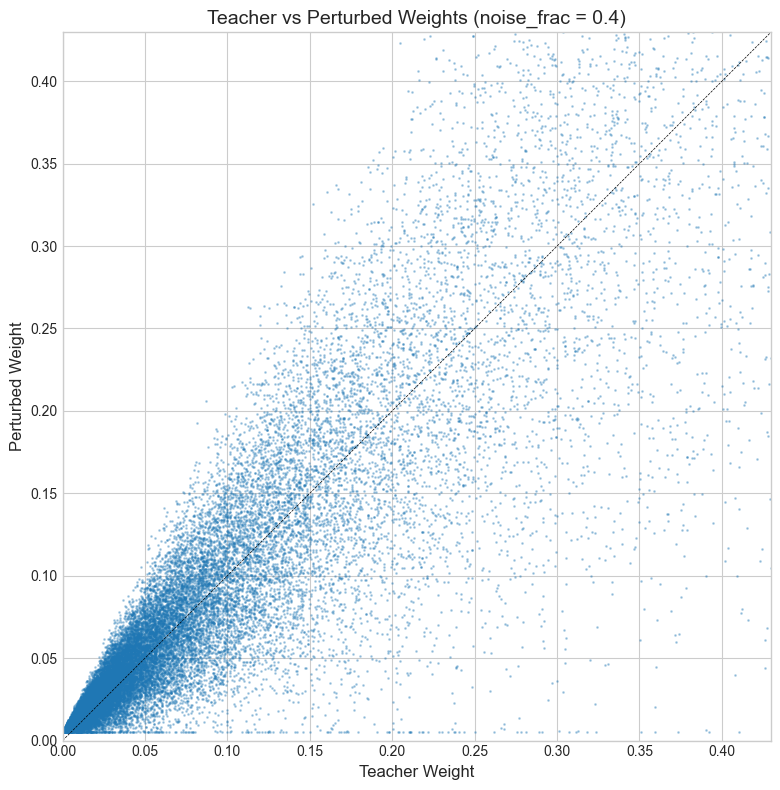


Weight statistics:
  Teacher mean: 0.1043, std: 0.3254
  Perturbed mean: 0.1043, std: 0.3254
  Correlation: 0.9155


In [24]:
# Scatter plot: Teacher vs Perturbed weights
# Only plot non-zero weights (where connections exist)
mask = teacher_weights != 0
teacher_flat = teacher_weights[mask]
perturbed_flat = perturbed_weights[mask]

print(f"Number of non-zero weights: {len(teacher_flat):,}")

# Subsample for plotting if too many points
max_points = 50000
if len(teacher_flat) > max_points:
    idx = np.random.choice(len(teacher_flat), max_points, replace=False)
    teacher_sample = teacher_flat[idx]
    perturbed_sample = perturbed_flat[idx]
    print(f"Subsampled to {max_points:,} points for plotting")
else:
    teacher_sample = teacher_flat
    perturbed_sample = perturbed_flat

fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(teacher_sample, perturbed_sample, alpha=0.3, s=1, c="C0")

# Use 95th percentile for axis limits
upper_lim = np.percentile(np.concatenate([teacher_flat, perturbed_flat]), 95)
lims = [0, upper_lim]

ax.plot(lims, lims, "k--", linewidth=0.5)

ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Teacher Weight", fontsize=12)
ax.set_ylabel("Perturbed Weight", fontsize=12)
ax.set_title(f"Teacher vs Perturbed Weights (noise_frac = {noise_frac})", fontsize=14)
ax.set_aspect("equal")

plt.tight_layout()
plt.show()

# Print some statistics
print("\nWeight statistics:")
print(f"  Teacher mean: {teacher_flat.mean():.4f}, std: {teacher_flat.std():.4f}")
print(f"  Perturbed mean: {perturbed_flat.mean():.4f}, std: {perturbed_flat.std():.4f}")
print(f"  Correlation: {np.corrcoef(teacher_flat, perturbed_flat)[0, 1]:.4f}")

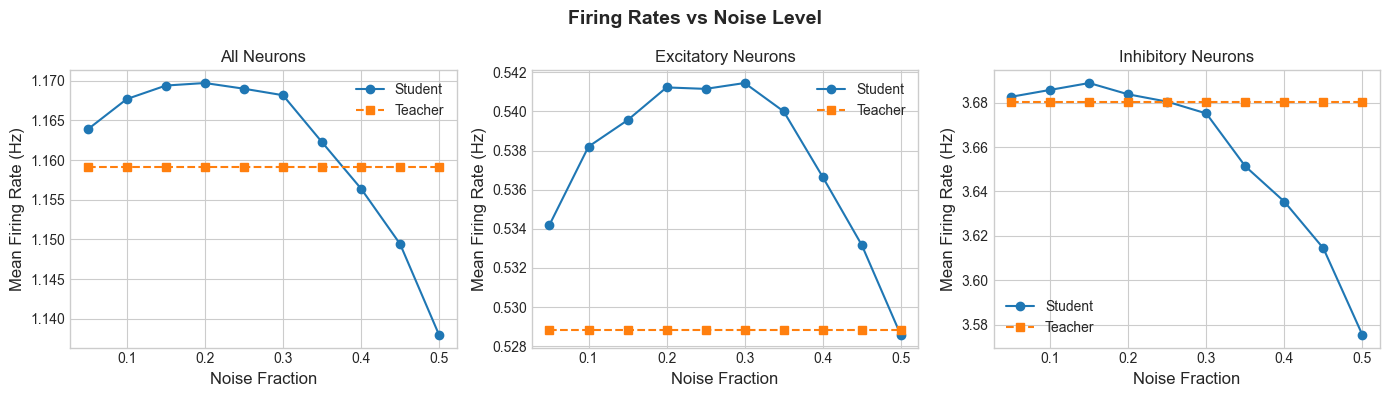


Firing rate summary at lowest noise (0.05):
  Student: all=1.16, exc=0.53, inh=3.68 Hz
  Teacher: all=1.16, exc=0.53, inh=3.68 Hz


In [25]:
# Plot firing rate vs noise level (student and teacher, by cell type)
# Now we have teacher firing rates logged in the metrics directly

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Overall mean firing rate
ax = axes[0]
ax.plot(results_df["noise_fraction"], results_df["student_firing_rate_mean"], 
        "o-", color="C0", markersize=6, label="Student")
ax.plot(results_df["noise_fraction"], results_df["teacher_firing_rate_mean"], 
        "s--", color="C1", markersize=6, label="Teacher")
ax.set_xlabel("Noise Fraction", fontsize=12)
ax.set_ylabel("Mean Firing Rate (Hz)", fontsize=12)
ax.set_title("All Neurons", fontsize=12)
ax.legend(loc="best")

# Excitatory neurons
ax = axes[1]
ax.plot(results_df["noise_fraction"], results_df["student_firing_rate_exc"], 
        "o-", color="C0", markersize=6, label="Student")
ax.plot(results_df["noise_fraction"], results_df["teacher_firing_rate_exc"], 
        "s--", color="C1", markersize=6, label="Teacher")
ax.set_xlabel("Noise Fraction", fontsize=12)
ax.set_ylabel("Mean Firing Rate (Hz)", fontsize=12)
ax.set_title("Excitatory Neurons", fontsize=12)
ax.legend(loc="best")

# Inhibitory neurons
ax = axes[2]
ax.plot(results_df["noise_fraction"], results_df["student_firing_rate_inh"], 
        "o-", color="C0", markersize=6, label="Student")
ax.plot(results_df["noise_fraction"], results_df["teacher_firing_rate_inh"], 
        "s--", color="C1", markersize=6, label="Teacher")
ax.set_xlabel("Noise Fraction", fontsize=12)
ax.set_ylabel("Mean Firing Rate (Hz)", fontsize=12)
ax.set_title("Inhibitory Neurons", fontsize=12)
ax.legend(loc="best")

plt.suptitle("Firing Rates vs Noise Level", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# Print summary
print("\nFiring rate summary at lowest noise (0.05):")
row = results_df[results_df["noise_fraction"] == 0.05].iloc[0]
print(f"  Student: all={row['student_firing_rate_mean']:.2f}, exc={row['student_firing_rate_exc']:.2f}, inh={row['student_firing_rate_inh']:.2f} Hz")
print(f"  Teacher: all={row['teacher_firing_rate_mean']:.2f}, exc={row['teacher_firing_rate_exc']:.2f}, inh={row['teacher_firing_rate_inh']:.2f} Hz")

## Convergence Analysis: Different Random Initializations

This section analyses the convergence behaviour of the network when starting from the same noise level but with different random seeds for the weight perturbation. The question is: does the network converge to the correct target regardless of the random initialization?

In [26]:
# Load convergence analysis data from random seed runs
convergence_dir = Path(
    "/tungstenfs/scratch/gzenke/bedfrory/dp-simulations/noisy-weights/convergence-check"
)

# Find all seed directories
seed_dirs = sorted(
    [
        d
        for d in convergence_dir.iterdir()
        if d.is_dir() and d.name.startswith("seed-")
    ]
)
print(f"Found {len(seed_dirs)} convergence check runs")

# Load trajectories from all runs
scaling_factor_names = [
    ("excitatory_to_excitatory", "Exc -> Exc"),
    ("excitatory_to_inhibitory", "Exc -> Inh"),
    ("inhibitory_to_excitatory", "Inh -> Exc"),
    ("inhibitory_to_inhibitory", "Inh -> Inh"),
    ("mitral_to_excitatory", "Mitral -> Exc"),
    ("mitral_to_inhibitory", "Mitral -> Inh"),
]

trajectories = {}
for seed_dir in seed_dirs:
    seed = int(seed_dir.name.split("-")[-1])
    metrics_path = seed_dir / "training_metrics.csv"
    if not metrics_path.exists():
        print(f"Warning: {metrics_path} not found, skipping")
        continue
    
    df = pd.read_csv(metrics_path)
    trajectories[seed] = {
        "epochs": df["epoch"].values,
    }
    
    # New flattened column names
    for sf_key, _ in scaling_factor_names:
        trajectories[seed][f"{sf_key}_value"] = df[f"scaling_factors/{sf_key}_value"].values
        trajectories[seed][f"{sf_key}_target"] = df[f"scaling_factors/{sf_key}_target"].values[0]
    
    # Also store firing rates
    trajectories[seed]["student_firing_rate_mean"] = df["firing_rate/student_mean"].values
    trajectories[seed]["teacher_firing_rate_mean"] = df["firing_rate/teacher_mean"].values
    trajectories[seed]["student_firing_rate_exc"] = df["firing_rate/student_excitatory_mean"].values
    trajectories[seed]["student_firing_rate_inh"] = df["firing_rate/student_inhibitory_mean"].values

print(f"Loaded trajectories for seeds: {sorted(trajectories.keys())}")

Found 10 convergence check runs
Loaded trajectories for seeds: [42, 43, 44, 45, 46, 47, 48, 49, 50, 51]


In [27]:
# Load and visualize the noisy weights used in convergence check
example_seed = 42
example_run_dir = convergence_dir / f"seed-{example_seed}"

# Load teacher weights
teacher_data_conv = np.load(example_run_dir / "inputs" / "network_structure.npz")
teacher_ff_weights = teacher_data_conv["feedforward_weights"]
teacher_rec_weights = teacher_data_conv["recurrent_weights"]
teacher_weights_conv = np.concatenate([teacher_ff_weights, teacher_rec_weights], axis=0)

# Load noise config
noise_config = np.load(example_run_dir / "targets" / "weight_noise_config.npz")
noise_frac_conv = float(noise_config["noise_frac"])
noise_seed = int(noise_config["seed"])

print(f"Convergence check weight noise:")
print(f"  Noise fraction: {noise_frac_conv}")
print(f"  Seed: {noise_seed}")
print(f"  Teacher weights shape: {teacher_weights_conv.shape}")

# Reconstruct the noisy weights using the same affine approach
weight_noise_rng = np.random.default_rng(noise_seed)
perturbed_weights_conv = apply_noise_affine(
    teacher_weights_conv, noise_frac_conv, rng=weight_noise_rng
)

print(f"Perturbed weights shape: {perturbed_weights_conv.shape}")

Convergence check weight noise:
  Noise fraction: 0.4
  Seed: 42
  Teacher weights shape: (6500, 5000)
Perturbed weights shape: (6500, 5000)


Number of non-zero weights: 1,852,500
Subsampled to 50,000 points for plotting


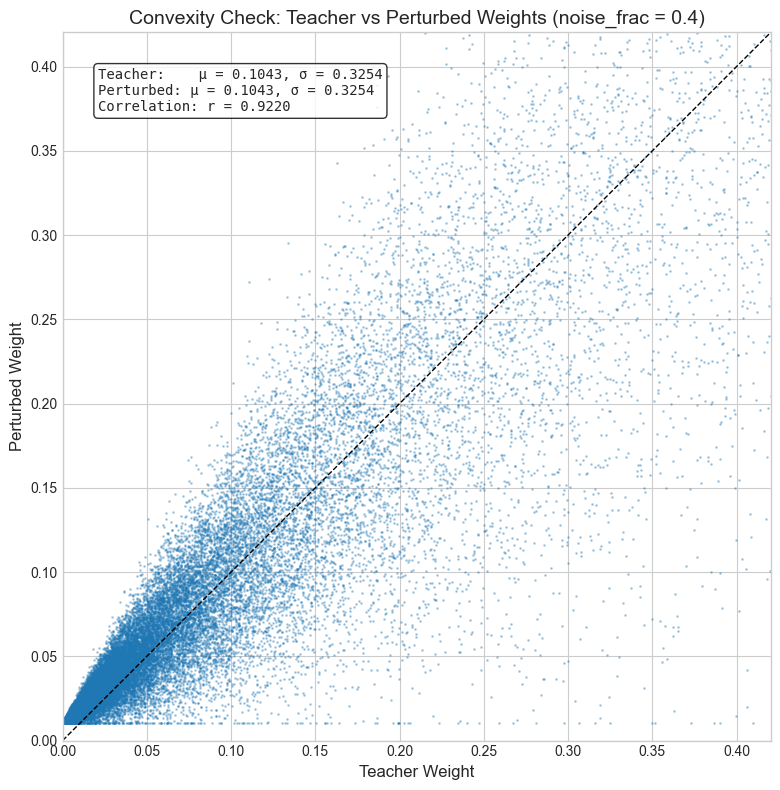

In [28]:
# Scatter plot: Teacher vs Perturbed weights with mean/std annotations
mask_conv = teacher_weights_conv != 0
teacher_flat_conv = teacher_weights_conv[mask_conv]
perturbed_flat_conv = perturbed_weights_conv[mask_conv]

print(f"Number of non-zero weights: {len(teacher_flat_conv):,}")

# Compute statistics
teacher_mean = teacher_flat_conv.mean()
teacher_std = teacher_flat_conv.std()
perturbed_mean = perturbed_flat_conv.mean()
perturbed_std = perturbed_flat_conv.std()
correlation = np.corrcoef(teacher_flat_conv, perturbed_flat_conv)[0, 1]

# Subsample for plotting
max_points = 50000
if len(teacher_flat_conv) > max_points:
    idx = np.random.choice(len(teacher_flat_conv), max_points, replace=False)
    teacher_sample_conv = teacher_flat_conv[idx]
    perturbed_sample_conv = perturbed_flat_conv[idx]
    print(f"Subsampled to {max_points:,} points for plotting")
else:
    teacher_sample_conv = teacher_flat_conv
    perturbed_sample_conv = perturbed_flat_conv

fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(teacher_sample_conv, perturbed_sample_conv, alpha=0.3, s=1, c="C0")

# Use 95th percentile for axis limits
upper_lim = np.percentile(np.concatenate([teacher_flat_conv, perturbed_flat_conv]), 95)
lims = [0, upper_lim]

ax.plot(lims, lims, "k--", linewidth=1, label="Identity")

ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Teacher Weight", fontsize=12)
ax.set_ylabel("Perturbed Weight", fontsize=12)
ax.set_title(f"Convexity Check: Teacher vs Perturbed Weights (noise_frac = {noise_frac_conv})", fontsize=14)
ax.set_aspect("equal")

# Add text box with statistics
stats_text = (
    f"Teacher:    μ = {teacher_mean:.4f}, σ = {teacher_std:.4f}\n"
    f"Perturbed: μ = {perturbed_mean:.4f}, σ = {perturbed_std:.4f}\n"
    f"Correlation: r = {correlation:.4f}"
)
ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

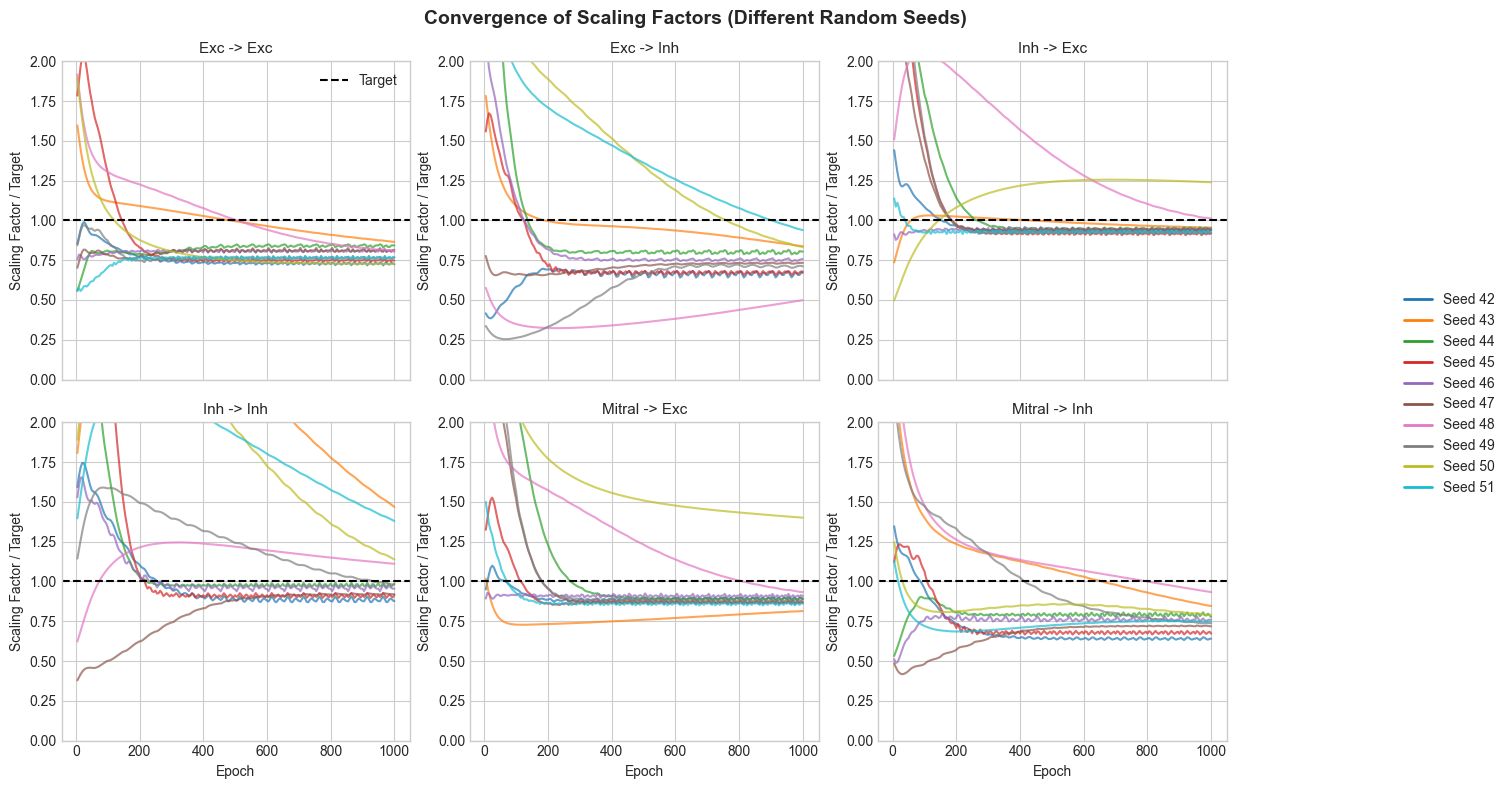

In [29]:
# Plot: Trajectories of scaling factors across all seeds
# Since targets are now normalized to 1.0, we can directly compare values
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True)

seeds = sorted(trajectories.keys())
colors = plt.cm.tab10(np.linspace(0, 1, len(seeds)))

for idx, (sf_key, sf_label) in enumerate(scaling_factor_names):
    ax = axes.flat[idx]
    
    for seed_idx, seed in enumerate(seeds):
        traj = trajectories[seed]
        epochs = traj["epochs"]
        values = traj[f"{sf_key}_value"]
        
        # Plot trajectory
        ax.plot(epochs, values, color=colors[seed_idx], alpha=0.7, linewidth=1.5)
    
    # Plot target line at 1.0 (all targets are normalized to 1)
    ax.axhline(y=1.0, color="black", linestyle="--", linewidth=1.5, label="Target")
    
    ax.set_title(sf_label, fontsize=11)
    ax.set_ylabel("Scaling Factor / Target")
    ax.set_ylim(0, 2)
    if idx >= 3:
        ax.set_xlabel("Epoch")
    if idx == 0:
        ax.legend(loc="upper right")

# Add a legend showing seed colors
handles = [plt.Line2D([0], [0], color=colors[i], linewidth=2) for i in range(len(seeds))]
labels = [f"Seed {s}" for s in seeds]
fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.08, 0.5))

plt.suptitle("Convergence of Scaling Factors (Different Random Seeds)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.subplots_adjust(right=0.88)
plt.show()

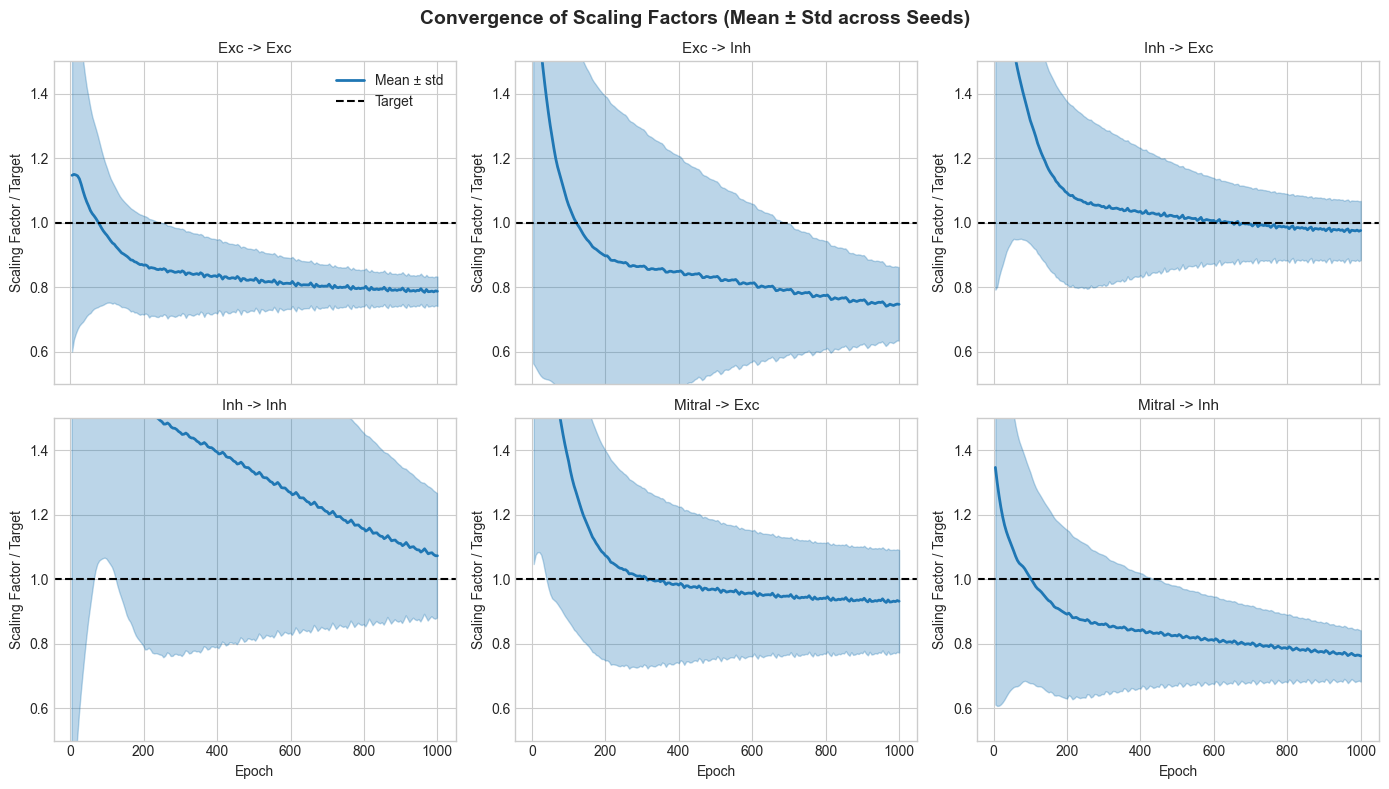

In [30]:
# Plot: Mean ± std of scaling factor trajectories across seeds
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True)

# Get common epoch grid (use the first seed's epochs as reference)
reference_seed = seeds[0]
epochs_ref = trajectories[reference_seed]["epochs"]

for idx, (sf_key, sf_label) in enumerate(scaling_factor_names):
    ax = axes.flat[idx]
    
    # Collect trajectories from all seeds
    all_values = []
    for seed in seeds:
        traj = trajectories[seed]
        values = traj[f"{sf_key}_value"]
        
        # Interpolate to reference epochs if different length
        if len(traj["epochs"]) != len(epochs_ref):
            values = np.interp(epochs_ref, traj["epochs"], values)
        
        all_values.append(values)
    
    all_values = np.array(all_values)  # (n_seeds, n_epochs)
    
    # Compute mean and std
    mean_traj = np.mean(all_values, axis=0)
    std_traj = np.std(all_values, axis=0)
    
    # Plot mean ± std
    ax.fill_between(epochs_ref, mean_traj - std_traj, mean_traj + std_traj, 
                    alpha=0.3, color="C0")
    ax.plot(epochs_ref, mean_traj, color="C0", linewidth=2, label="Mean ± std")
    
    # Plot target line at 1.0
    ax.axhline(y=1.0, color="black", linestyle="--", linewidth=1.5, label="Target")
    
    ax.set_title(sf_label, fontsize=11)
    ax.set_ylabel("Scaling Factor / Target")
    ax.set_ylim(0.5, 1.5)
    if idx >= 3:
        ax.set_xlabel("Epoch")
    if idx == 0:
        ax.legend(loc="upper right")

plt.suptitle("Convergence of Scaling Factors (Mean ± Std across Seeds)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

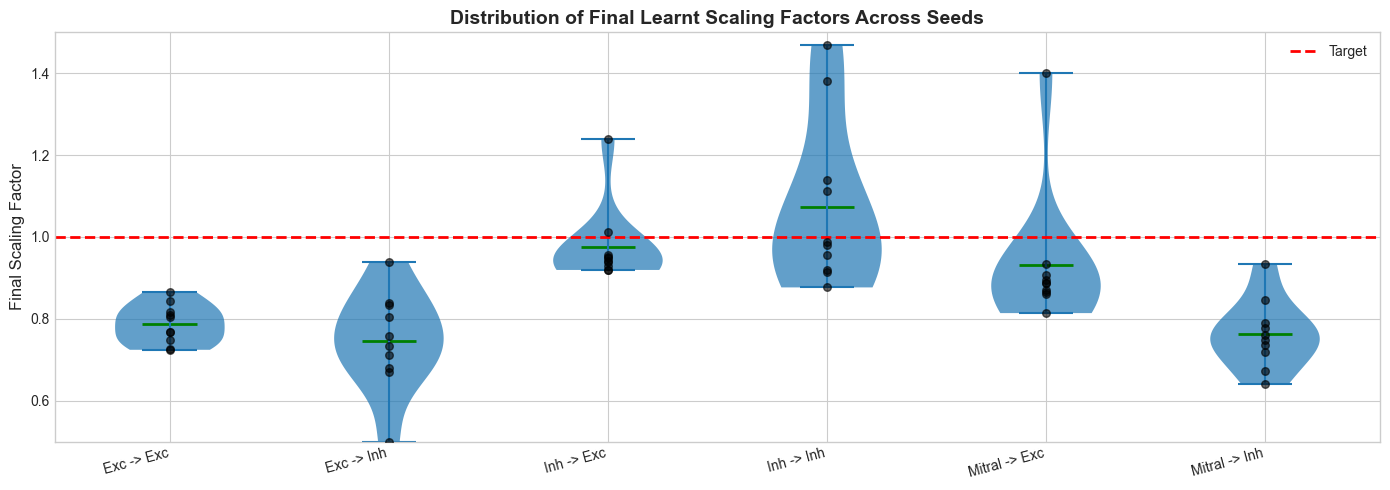


Summary Statistics (Final Scaling Factor Values):
----------------------------------------------------------------------
Exc -> Exc          : mean=0.7868, std=0.0454, min=0.7242, max=0.8650
Exc -> Inh          : mean=0.7464, std=0.1138, min=0.4987, max=0.9394
Inh -> Exc          : mean=0.9754, std=0.0917, min=0.9193, max=1.2400
Inh -> Inh          : mean=1.0732, std=0.1932, min=0.8766, max=1.4684
Mitral -> Exc       : mean=0.9321, std=0.1592, min=0.8138, max=1.4010
Mitral -> Inh       : mean=0.7623, std=0.0794, min=0.6407, max=0.9332


In [31]:
# Plot: Distribution of final learnt scaling factors as violin plot
fig, ax = plt.subplots(figsize=(14, 5))

# Collect final values for all scaling factors
violin_data = []
violin_labels = []

for sf_key, sf_label in scaling_factor_names:
    final_values = [trajectories[seed][f"{sf_key}_value"][-1] for seed in seeds]
    violin_data.append(final_values)
    violin_labels.append(sf_label)

# Create violin plot
parts = ax.violinplot(violin_data, positions=range(len(scaling_factor_names)), 
                       showmeans=True, showmedians=False)

# Style the violins
for pc in parts['bodies']:
    pc.set_facecolor('C0')
    pc.set_alpha(0.7)
parts['cmeans'].set_color('green')
parts['cmeans'].set_linewidth(2)

# Add individual points
for i, data in enumerate(violin_data):
    ax.scatter([i] * len(data), data, color='black', s=30, alpha=0.6, zorder=3)

# Add target line
ax.axhline(y=1.0, color="red", linestyle="--", linewidth=2, label="Target")

# Formatting
ax.set_xticks(range(len(scaling_factor_names)))
ax.set_xticklabels(violin_labels, rotation=15, ha='right')
ax.set_ylabel("Final Scaling Factor", fontsize=12)
ax.set_ylim(0.5, 1.5)
ax.legend(loc="upper right")

plt.title("Distribution of Final Learnt Scaling Factors Across Seeds", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics (Final Scaling Factor Values):")
print("-" * 70)
for i, (sf_key, sf_label) in enumerate(scaling_factor_names):
    vals = np.array(violin_data[i])
    print(f"{sf_label:20s}: mean={np.mean(vals):.4f}, std={np.std(vals):.4f}, "
          f"min={np.min(vals):.4f}, max={np.max(vals):.4f}")

Checking scaling factor RATIOS (learned / learned, normalized by target ratio)
If balanced scaling hypothesis is correct, these should all be close to 1.0


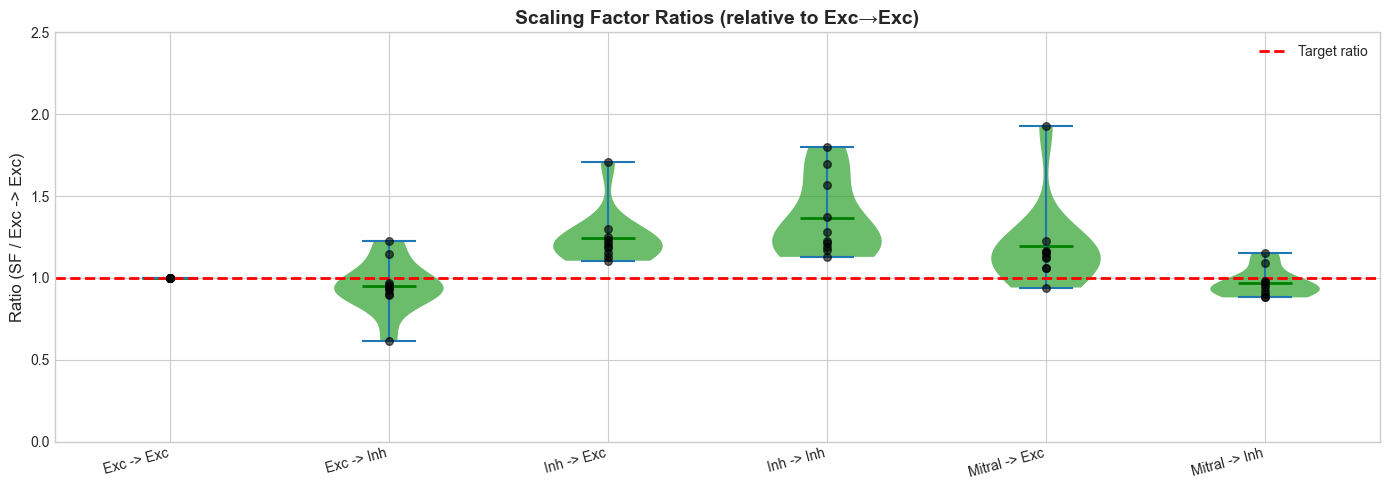


Ratios relative to Exc -> Exc:
----------------------------------------------------------------------
Exc -> Exc          : mean=1.0000, std=0.0000
Exc -> Inh          : mean=0.9513, std=0.1521
Inh -> Exc          : mean=1.2460, std=0.1631
Inh -> Inh          : mean=1.3637, std=0.2272
Mitral -> Exc       : mean=1.1942, std=0.2556
Mitral -> Inh       : mean=0.9688, std=0.0845

Global scaling factor (mean across all SF types):
----------------------------------------------------------------------
Seed 42: mean SF = 0.7914 (all weights scaled by ~79.1%)
Seed 43: mean SF = 0.9644 (all weights scaled by ~96.4%)
Seed 44: mean SF = 0.8758 (all weights scaled by ~87.6%)
Seed 45: mean SF = 0.7990 (all weights scaled by ~79.9%)
Seed 46: mean SF = 0.8553 (all weights scaled by ~85.5%)
Seed 47: mean SF = 0.8320 (all weights scaled by ~83.2%)
Seed 48: mean SF = 0.8829 (all weights scaled by ~88.3%)
Seed 49: mean SF = 0.8339 (all weights scaled by ~83.4%)
Seed 50: mean SF = 1.0216 (all weights scal

In [32]:
# Check if the RATIOS between scaling factors are preserved
# If all scaling factors are off by the same constant, ratios should be ~1.0

# Get all pairwise ratios for each seed
print("Checking scaling factor RATIOS (learned / learned, normalized by target ratio)")
print("If balanced scaling hypothesis is correct, these should all be close to 1.0")
print("=" * 80)

# For each seed, compute the ratio of each scaling factor to a reference (e.g., exc_to_exc)
reference_sf = "excitatory_to_excitatory"
ref_idx = 0

ratio_data = {sf_key: [] for sf_key, _ in scaling_factor_names}

for seed in seeds:
    traj = trajectories[seed]
    ref_value = traj[f"{reference_sf}_value"][-1]
    
    for sf_key, sf_label in scaling_factor_names:
        learned_value = traj[f"{sf_key}_value"][-1]
        # Since targets are all 1.0, the target ratio is also 1.0
        # So the learned ratio should equal learned_value / ref_value
        ratio = learned_value / ref_value
        ratio_data[sf_key].append(ratio)

# Plot ratios
fig, ax = plt.subplots(figsize=(14, 5))

ratio_values = [ratio_data[sf_key] for sf_key, _ in scaling_factor_names]
ratio_labels = [sf_label for _, sf_label in scaling_factor_names]

parts = ax.violinplot(ratio_values, positions=range(len(scaling_factor_names)), 
                       showmeans=True, showmedians=False)

for pc in parts['bodies']:
    pc.set_facecolor('C2')
    pc.set_alpha(0.7)
parts['cmeans'].set_color('green')
parts['cmeans'].set_linewidth(2)

for i, data in enumerate(ratio_values):
    ax.scatter([i] * len(data), data, color='black', s=30, alpha=0.6, zorder=3)

# Target ratio line at 1.0
ax.axhline(y=1.0, color="red", linestyle="--", linewidth=2, label="Target ratio")

ax.set_xticks(range(len(scaling_factor_names)))
ax.set_xticklabels(ratio_labels, rotation=15, ha='right')
ax.set_ylabel(f"Ratio (SF / {scaling_factor_names[0][1]})", fontsize=12)
ax.set_ylim(0, 2.5)
ax.legend(loc="upper right")

plt.title("Scaling Factor Ratios (relative to Exc→Exc)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# Print ratio statistics
print(f"\nRatios relative to {scaling_factor_names[0][1]}:")
print("-" * 70)
for (sf_key, sf_label), ratios in zip(scaling_factor_names, ratio_values):
    ratios = np.array(ratios)
    print(f"{sf_label:20s}: mean={np.mean(ratios):.4f}, std={np.std(ratios):.4f}")

# Also check the global scaling factor (mean of all scaling factors)
print("\n" + "=" * 80)
print("Global scaling factor (mean across all SF types):")
print("-" * 70)
for seed in seeds:
    traj = trajectories[seed]
    all_sf = [traj[f"{sf_key}_value"][-1] for sf_key, _ in scaling_factor_names]
    mean_sf = np.mean(all_sf)
    print(f"Seed {seed}: mean SF = {mean_sf:.4f} (all weights scaled by ~{mean_sf:.1%})")

all_means = []
for seed in seeds:
    traj = trajectories[seed]
    all_sf = [traj[f"{sf_key}_value"][-1] for sf_key, _ in scaling_factor_names]
    all_means.append(np.mean(all_sf))
print(f"\nOverall: {np.mean(all_means):.4f} ± {np.std(all_means):.4f}")

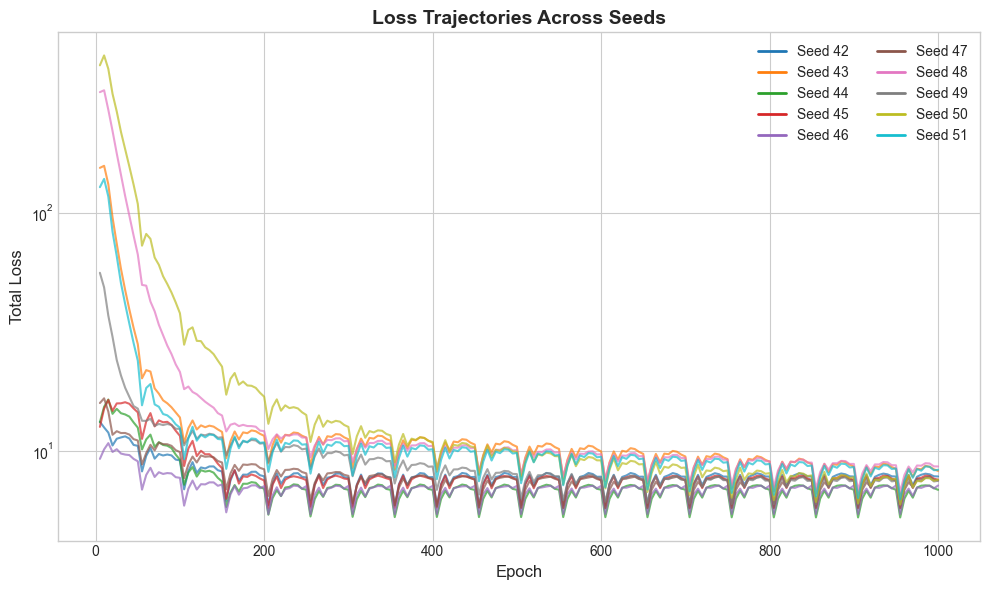


Final losses:
  Seed 42: 7.819911
  Seed 43: 8.250322
  Seed 44: 6.870010
  Seed 45: 7.579601
  Seed 46: 7.165610
  Seed 47: 7.522374
  Seed 48: 8.615405
  Seed 49: 7.493657
  Seed 50: 7.574354
  Seed 51: 8.338423


In [33]:
# Plot loss trajectories across seeds
fig, ax = plt.subplots(figsize=(10, 6))

for seed_idx, seed in enumerate(seeds):
    seed_dir = convergence_dir / f"seed-{seed}"
    metrics_df = pd.read_csv(seed_dir / "training_metrics.csv")
    ax.plot(metrics_df["epoch"], metrics_df["total_loss"], 
            color=colors[seed_idx], alpha=0.7, linewidth=1.5)

ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Total Loss", fontsize=12)
ax.set_title("Loss Trajectories Across Seeds", fontsize=14, fontweight="bold")
ax.set_yscale("log")

# Add legend
handles = [plt.Line2D([0], [0], color=colors[i], linewidth=2) for i in range(len(seeds))]
labels = [f"Seed {s}" for s in seeds]
ax.legend(handles, labels, loc="upper right", ncol=2)

plt.tight_layout()
plt.show()

# Print final losses
print("\nFinal losses:")
for seed in seeds:
    seed_dir = convergence_dir / f"seed-{seed}"
    metrics_df = pd.read_csv(seed_dir / "training_metrics.csv")
    print(f"  Seed {seed}: {metrics_df['total_loss'].iloc[-1]:.6f}")

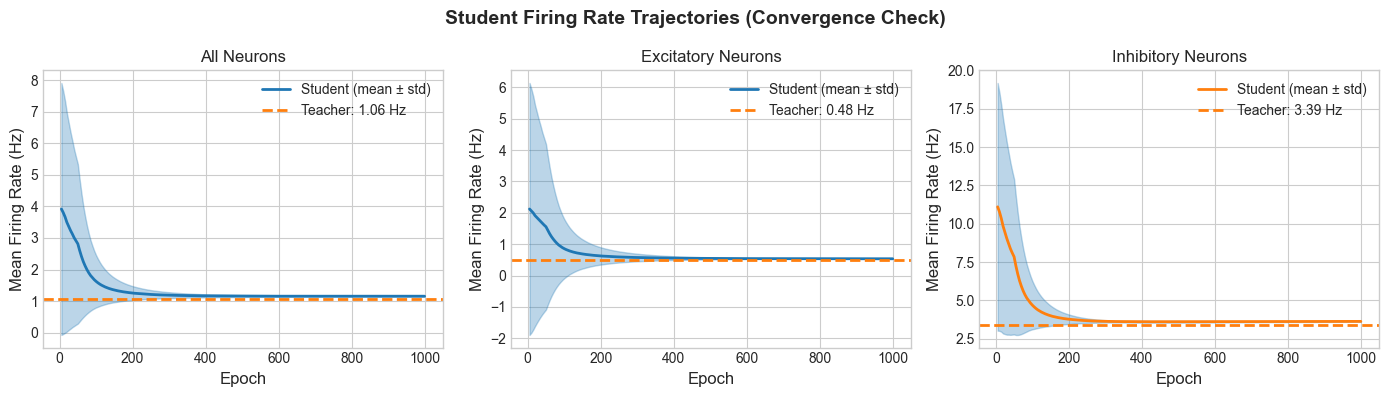

In [34]:
# Plot firing rate trajectories (mean ± std across seeds)
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Collect firing rate trajectories
fr_mean_all = []
fr_exc_all = []
fr_inh_all = []

for seed in seeds:
    traj = trajectories[seed]
    epochs_seed = traj["epochs"]
    
    # Interpolate to common epoch grid
    fr_mean = np.interp(epochs_ref, epochs_seed, traj["student_firing_rate_mean"])
    fr_exc = np.interp(epochs_ref, epochs_seed, traj["student_firing_rate_exc"])
    fr_inh = np.interp(epochs_ref, epochs_seed, traj["student_firing_rate_inh"])
    
    fr_mean_all.append(fr_mean)
    fr_exc_all.append(fr_exc)
    fr_inh_all.append(fr_inh)

fr_mean_all = np.array(fr_mean_all)
fr_exc_all = np.array(fr_exc_all)
fr_inh_all = np.array(fr_inh_all)

# Get teacher firing rates (should be same across seeds)
teacher_fr_mean = trajectories[seeds[0]]["teacher_firing_rate_mean"][0]
seed_dir = convergence_dir / f"seed-{seeds[0]}"
metrics_df = pd.read_csv(seed_dir / "training_metrics.csv")
teacher_fr_exc = metrics_df["firing_rate/teacher_excitatory_mean"].iloc[0]
teacher_fr_inh = metrics_df["firing_rate/teacher_inhibitory_mean"].iloc[0]

# Plot: All neurons
ax = axes[0]
mean_traj = fr_mean_all.mean(axis=0)
std_traj = fr_mean_all.std(axis=0)
ax.fill_between(epochs_ref, mean_traj - std_traj, mean_traj + std_traj, alpha=0.3, color="C0")
ax.plot(epochs_ref, mean_traj, color="C0", linewidth=2, label="Student (mean ± std)")
ax.axhline(y=teacher_fr_mean, color="C1", linestyle="--", linewidth=2, label=f"Teacher: {teacher_fr_mean:.2f} Hz")
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Mean Firing Rate (Hz)", fontsize=12)
ax.set_title("All Neurons", fontsize=12)
ax.legend(loc="best")

# Plot: Excitatory neurons
ax = axes[1]
mean_traj = fr_exc_all.mean(axis=0)
std_traj = fr_exc_all.std(axis=0)
ax.fill_between(epochs_ref, mean_traj - std_traj, mean_traj + std_traj, alpha=0.3, color="C0")
ax.plot(epochs_ref, mean_traj, color="C0", linewidth=2, label="Student (mean ± std)")
ax.axhline(y=teacher_fr_exc, color="C1", linestyle="--", linewidth=2, label=f"Teacher: {teacher_fr_exc:.2f} Hz")
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Mean Firing Rate (Hz)", fontsize=12)
ax.set_title("Excitatory Neurons", fontsize=12)
ax.legend(loc="best")

# Plot: Inhibitory neurons
ax = axes[2]
mean_traj = fr_inh_all.mean(axis=0)
std_traj = fr_inh_all.std(axis=0)
ax.fill_between(epochs_ref, mean_traj - std_traj, mean_traj + std_traj, alpha=0.3, color="C0")
ax.plot(epochs_ref, mean_traj, color="C1", linewidth=2, label="Student (mean ± std)")
ax.axhline(y=teacher_fr_inh, color="C1", linestyle="--", linewidth=2, label=f"Teacher: {teacher_fr_inh:.2f} Hz")
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Mean Firing Rate (Hz)", fontsize=12)
ax.set_title("Inhibitory Neurons", fontsize=12)
ax.legend(loc="best")

plt.suptitle("Student Firing Rate Trajectories (Convergence Check)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

### Summary: Comparing Varying Noise and Convergence Check Results

Let's compare key metrics between the two experiments to understand how noise level and random initialization affect convergence.

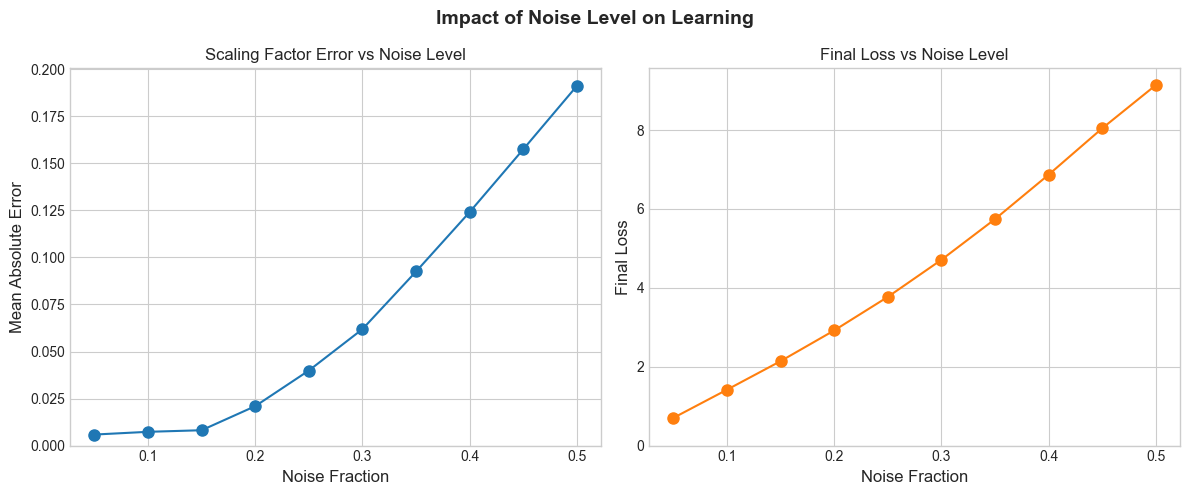


Correlation between noise and final loss: 0.9957


In [35]:
# Summary: Final scaling factor errors vs noise level
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Mapping from long names to short names used in results_df
sf_short_names = [
    "exc_to_exc", "exc_to_inh", "inh_to_exc", 
    "inh_to_inh", "mitral_to_exc", "mitral_to_inh"
]

# Left: Mean absolute error of scaling factors vs noise level
ax = axes[0]
errors_by_noise = []
for _, row in results_df.iterrows():
    errors = []
    for sf_short in sf_short_names:
        error = abs(row[f"{sf_short}_value"] - 1.0)
        errors.append(error)
    errors_by_noise.append(np.mean(errors))

ax.plot(results_df["noise_fraction"], errors_by_noise, "o-", color="C0", markersize=8)
ax.set_xlabel("Noise Fraction", fontsize=12)
ax.set_ylabel("Mean Absolute Error", fontsize=12)
ax.set_title("Scaling Factor Error vs Noise Level", fontsize=12)
ax.set_ylim(0, None)

# Right: Final loss vs noise level
ax = axes[1]
ax.plot(results_df["noise_fraction"], results_df["final_loss"], "o-", color="C1", markersize=8)
ax.set_xlabel("Noise Fraction", fontsize=12)
ax.set_ylabel("Final Loss", fontsize=12)
ax.set_title("Final Loss vs Noise Level", fontsize=12)
ax.set_ylim(0, None)

plt.suptitle("Impact of Noise Level on Learning", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# Print correlation
print(f"\nCorrelation between noise and final loss: {np.corrcoef(results_df['noise_fraction'], results_df['final_loss'])[0,1]:.4f}")

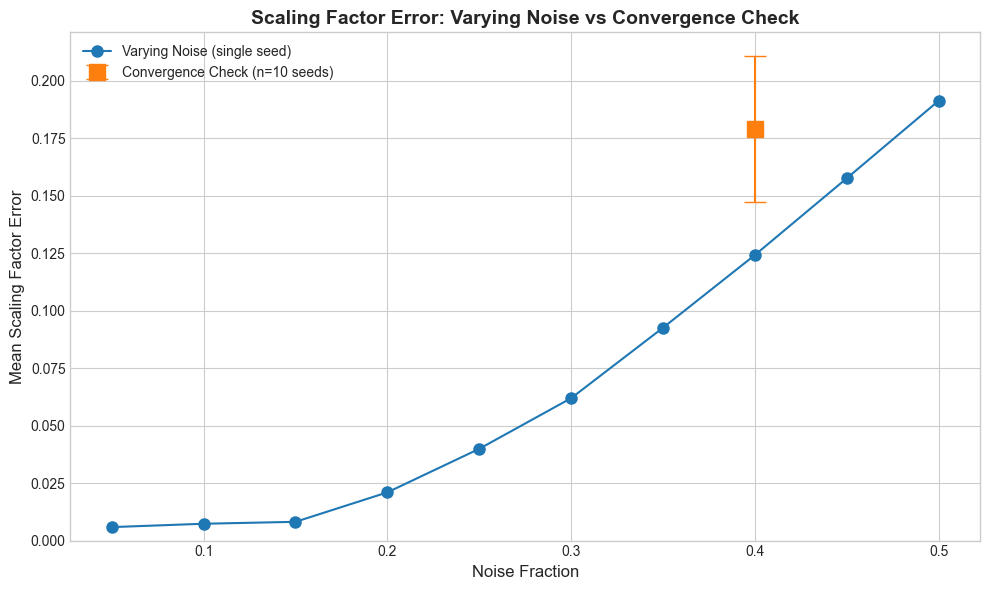


Convergence check (noise=0.4):
  Mean error: 0.1790 ± 0.0317
  Range: [0.1242, 0.2383]


In [36]:
# Compare convergence check variance with varying noise results
fig, ax = plt.subplots(figsize=(10, 6))

# Convergence check: variance across seeds at fixed noise level
conv_noise_level = noise_frac_conv  # Should be 0.4

# Get final scaling factor errors for convergence check
conv_final_errors = []
for seed in seeds:
    traj = trajectories[seed]
    errors = []
    for sf_key, _ in scaling_factor_names:
        error = abs(traj[f"{sf_key}_value"][-1] - 1.0)
        errors.append(error)
    conv_final_errors.append(np.mean(errors))

conv_final_errors = np.array(conv_final_errors)

# Plot varying noise results
ax.errorbar(results_df["noise_fraction"], errors_by_noise, 
            fmt="o-", color="C0", markersize=8, capsize=5,
            label="Varying Noise (single seed)")

# Add convergence check point with error bars
ax.errorbar([conv_noise_level], [conv_final_errors.mean()], 
            yerr=[conv_final_errors.std()],
            fmt="s", color="C1", markersize=12, capsize=8,
            label=f"Convergence Check (n={len(seeds)} seeds)")

ax.set_xlabel("Noise Fraction", fontsize=12)
ax.set_ylabel("Mean Scaling Factor Error", fontsize=12)
ax.set_title("Scaling Factor Error: Varying Noise vs Convergence Check", fontsize=14, fontweight="bold")
ax.legend(loc="upper left")
ax.set_ylim(0, None)

plt.tight_layout()
plt.show()

print(f"\nConvergence check (noise={conv_noise_level}):")
print(f"  Mean error: {conv_final_errors.mean():.4f} ± {conv_final_errors.std():.4f}")
print(f"  Range: [{conv_final_errors.min():.4f}, {conv_final_errors.max():.4f}]")

In [37]:
# Final summary table
print("=" * 80)
print("SUMMARY: Noisy Weight Experiments")
print("=" * 80)

print("\n1. VARYING NOISE EXPERIMENT")
print("-" * 40)
print(f"   Noise levels tested: {list(results_df['noise_fraction'].values)}")
print(f"   Final epoch: {results_df['final_epoch'].iloc[0]:.0f}")

print("\n   Results by noise level:")
for _, row in results_df.iterrows():
    sf_errors = [abs(row[f"{k}_value"] - 1.0) for k in sf_short_names]
    print(f"   noise={row['noise_fraction']:.2f}: loss={row['final_loss']:.4f}, "
          f"SF error={np.mean(sf_errors):.4f}")

print("\n2. CONVERGENCE CHECK EXPERIMENT")
print("-" * 40)
print(f"   Fixed noise level: {conv_noise_level}")
print(f"   Number of seeds: {len(seeds)}")
print(f"   Seeds tested: {seeds}")

print("\n   Final scaling factor summary:")
for sf_key, sf_label in scaling_factor_names:
    vals = [trajectories[s][f"{sf_key}_value"][-1] for s in seeds]
    print(f"   {sf_label:20s}: {np.mean(vals):.4f} ± {np.std(vals):.4f} (target=1.0)")

print("\n3. KEY FINDINGS")
print("-" * 40)
# Calculate how many converged to within 5% of target
n_converged = sum(1 for e in conv_final_errors if e < 0.05)
print(f"   - {n_converged}/{len(seeds)} seeds converged within 5% of target")
print(f"   - Mean final error: {conv_final_errors.mean():.4f}")
print(f"   - Loss increases roughly linearly with noise level")

print("\n" + "=" * 80)

SUMMARY: Noisy Weight Experiments

1. VARYING NOISE EXPERIMENT
----------------------------------------
   Noise levels tested: [np.float64(0.05), np.float64(0.1), np.float64(0.15), np.float64(0.2), np.float64(0.25), np.float64(0.3), np.float64(0.35), np.float64(0.4), np.float64(0.45), np.float64(0.5)]
   Final epoch: 1000

   Results by noise level:
   noise=0.05: loss=0.7020, SF error=0.0059
   noise=0.10: loss=1.4168, SF error=0.0073
   noise=0.15: loss=2.1413, SF error=0.0082
   noise=0.20: loss=2.9200, SF error=0.0210
   noise=0.25: loss=3.7705, SF error=0.0399
   noise=0.30: loss=4.7116, SF error=0.0619
   noise=0.35: loss=5.7436, SF error=0.0925
   noise=0.40: loss=6.8700, SF error=0.1242
   noise=0.45: loss=8.0468, SF error=0.1575
   noise=0.50: loss=9.1426, SF error=0.1912

2. CONVERGENCE CHECK EXPERIMENT
----------------------------------------
   Fixed noise level: 0.4
   Number of seeds: 10
   Seeds tested: [42, 43, 44, 45, 46, 47, 48, 49, 50, 51]

   Final scaling factor s